## Семинар 7: "Методы оптимизации"

ФИО: Усцов Артем Алексеевич

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
from matplotlib import cm
import torch
from tqdm.auto import tqdm
from torch import nn
from torch.nn import NLLLoss, Sequential, Linear, Sigmoid, ELU, Tanh, L1Loss, Module, Parameter
from torch.autograd import Variable
from matplotlib.pyplot import cm
from matplotlib.colors import LogNorm
from torchvision import datasets, transforms

from IPython.display import clear_output

%matplotlib inline

На этом семинаре мы попробуем сравнить различные методы оптимизации: GD, Momentum, NAG, Adagrad, RMSProp, Adadelta, Adam.

### Часть 1: Реализация методов
<i> Реализуйте методы GD, Momentum, NAG, RMSProp, Adagrad, Adadelta, Adam.</i>

Полезная функция: __plt.contour__  
Для всех экспериментов подберите параметры так, чтобы метод сошелся к ближайшему локальному минимуму.  
Все методы следует запускать из одной и той же точки.

In [2]:
class Optimizer:
    def __init__(self, parameters):
        self.parameters = list(parameters)

    def zero_grad(self):
        for parameter in self.parameters:
            if parameter.grad is not None:
                parameter.grad.detach_()
                parameter.grad.zero_()
    
    def pre_step(self):
        pass
    
    def step(self):
        pass
    
    def update_param(self, parameter):
        raise NotImplementedError()

In [3]:
def optimize_function(fn, optim, optim_args, start_point, num_iter=50):
    weigths = nn.Parameter(torch.FloatTensor(start_point), requires_grad=True)

    optim = optim(parameters=[weigths], **optim_args)
    points = []
    losses = []
    for i in range(num_iter):
        if hasattr(optim, 'pre_step'):
            optim.pre_step()
        loss = fn(weigths[0], weigths[1])
        points.append(weigths.data.detach().clone())
        losses.append(loss.item())
        loss.backward()
        optim.step()
        optim.zero_grad()
    points = torch.stack(points, axis=0)
    losses = torch.FloatTensor(losses)
    return points, losses


In [4]:
def compare_optimizers(
    fn,
    optim_list,
    start_point,
    x_range=(-5, 5),
    y_range=(-5, 5),
    xstep=0.2,
    ystep=0.2,
    minima=None,
    num_iter = 50,
):
    """
    Draw level lines with optimizer behaviour
    """
    xmin, xmax = x_range
    ymin, ymax = y_range
    x, y = np.meshgrid(np.arange(xmin, xmax + xstep, xstep), np.arange(ymin, ymax + ystep, ystep))
    z = fn(torch.from_numpy(x), torch.from_numpy(y))
    z = z.detach().numpy()
    fig, ax = plt.subplots(figsize=(12, 8))

    ax.contour(x, y, z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)
    if minima:
        ax.plot(*minima, 'r*', markersize=18)

    fig.suptitle("Level lines of optimezed function")
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')

    ax.set_xlim((xmin, xmax))
    ax.set_ylim((ymin, ymax))
    
    colors = cm.rainbow(np.linspace(0, 1, len(optim_list)))
    name_losses = {}
    
    for c, (name, optim, args) in zip(colors, optim_list):
        points, losses = optimize_function(fn, optim, args, start_point, num_iter)
        ax.quiver(
            points[:-1, 0], points[:-1, 1],  
            points[1:, 0] - points[:-1, 0], points[1:, 1] - points[:-1, 1], 
            scale_units='xy', angles='xy', scale=1, color=c,
            label=name
        )
        name_losses[name] = losses
    
    ax.legend()
    plt.show()
        
    plt.figure(figsize=(12, 8))
    plt.title("Loss behaviour in learning")
    plt.xlabel("Num of iteration")
    plt.ylabel("Loss")
    x = np.arange(0, num_iter)
    for name, losses in name_losses.items():
        plt.plot(x, losses.numpy(), label=name)
    plt.legend()
    plt.grid(True)
    plt.show()

#### Stochastic Gradient Descent
$
\begin{eqnarray}
grad &=& \frac{1}{m}\nabla_w \sum_i L(f(x_{i};w), y_{i}) \\
w &=& w - \eta \times grad
\end{eqnarray}
$

In [5]:
class SGD(Optimizer):
    def __init__(self, parameters, learning_rate=0.01):
        super().__init__(parameters)
        self.learning_rate = learning_rate
        
    def step(self):
        with torch.no_grad(): # игнорируется для расчета градиентов
            for param in self.parameters:
                if param.grad is None:
                    continue
                param -= self.learning_rate * param.grad

#### Momentum SGD
$
\begin{eqnarray}
grad &=& \frac{1}{m}\nabla_w \sum_i L(f(x_{i};w), y_{i}) \\
v &=& \gamma * v + \eta \times grad \\
w &=& w - v
\end{eqnarray}
$

In [6]:
class Momentum(Optimizer):
    def __init__(self, parameters, learning_rate=0.01, gamma=0.9):
        super().__init__(parameters)
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.V = [torch.zeros_like(param) for param in self.parameters]

    def step(self):
        with torch.no_grad():
            for v, param in zip(self.V, self.parameters):
                v.copy_(self.gamma * v + self.learning_rate * param.grad)
                param -= v

#### Nesterov Adaptive Gradient (NAG)
$
\begin{eqnarray}
grad &=& \frac{1}{m}\nabla_w \sum_i L(f(x_{i};w_{t}), y_{i}) \\
w &=& w + v \\
v &=& \gamma * v + \eta \times grad \\
w &=& w - v
\end{eqnarray}
$

In [7]:
class NAG(Optimizer):
    def __init__(self, parameters, learning_rate=0.01, gamma=0.9):
        super().__init__(parameters)
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.V = [torch.zeros_like(param) for param in self.parameters]
        
    def step(self): 
        with torch.no_grad():
            for v, param in zip(self.V, self.parameters):
                param -= v

        with torch.no_grad():
            for v, param in zip(self.V, self.parameters):
                param += v
                v.copy_(self.gamma * v + self.learning_rate * param.grad)
                param -= v

#### RMSProp
$
\begin{eqnarray}
grad &=& \frac{1}{m}\nabla_w \sum_i L(f(x_{i};w), y_{i}) \\
G &=& \gamma G + (1 - \gamma) diag(grad * grad^{T}) \\
w &=& w - \frac{\eta}{\sqrt{G+eps}} \odot grad
\end{eqnarray}
$

In [8]:
class RMSProp(Optimizer):
    def __init__(self, parameters, learning_rate=0.01, gamma=0.9):
        super().__init__(parameters)
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.G = [torch.zeros_like(param) for param in self.parameters]
        self.eps = 10e-8
    
    def step(self):
        with torch.no_grad():
            for g, param in zip(self.G, self.parameters):
                g.copy_(self.gamma * g + (1 - self.gamma) * param.grad**2)
                param -= self.learning_rate / torch.sqrt(g + self.eps) * param.grad

#### AdaGrad
$
\begin{eqnarray}
grad &=& \frac{1}{m}\nabla_w \sum_i L(f(x_{i};w), y_{i}) \\
G &=& G + diag(grad * grad^{T}) \\
w &=& w - \frac{\eta}{\sqrt{G+eps}} \odot grad
\end{eqnarray}
$

In [9]:
class AdaGrad(Optimizer):
    def __init__(self, parameters, learning_rate=0.01):
        super().__init__(parameters)
        self.learning_rate = learning_rate
        self.eps = 10e-8
        self.G = [torch.zeros_like(param) for param in self.parameters]
    
    def step(self):
        with torch.no_grad():
            for g, param in zip(self.G, self.parameters):
                g.copy_(g + param.grad**2)
                param -= self.learning_rate / torch.sqrt(g + self.eps) * param.grad

#### Adadelta
$
\begin{eqnarray}
grad &=& \frac{1}{m}\nabla_w \sum_i L(f(x_{i};w), y_{i}) \\
G &=& G + diag(grad* grad^{T}) \\
grad' &=& \frac{\sqrt{\Delta w+eps}}{\sqrt{G+eps}} \odot grad \\
\Delta w &=& \gamma \Delta w + (1 - \rho) * diag(grad'* grad'^{T}) \\
w &=& w - grad'
\end{eqnarray}
$

In [10]:
class Adadelta(Optimizer):
    def __init__(self, parameters, gamma=0.9):
        super().__init__(parameters)
        
        self.gamma = gamma
        self.eps = 10e-8
        self.G = [torch.zeros_like(param) for param in self.parameters]
        self.D_Theta = [torch.zeros_like(param) for param in self.parameters]
        
    
    def step(self):
        with torch.no_grad():
            for g, d_theta, param in zip(self.G, self.D_Theta, self.parameters):
                g.copy_(self.gamma * g + (1 - self.gamma) * param.grad**2)
                param_hat = (torch.sqrt(d_theta + self.eps) / torch.sqrt(g + self.eps)) * param.grad
                d_theta.copy_(self.gamma * d_theta + (1 - self.gamma) * param_hat**2)
                param -= param_hat

#### Adam
$
\begin{eqnarray}
g &=& \frac{1}{m}\nabla_w \sum_i L(f(x_{i};w), y_{i}) \\
m &=& \beta_1 m + (1 - \beta_1) g \\
v &=& \beta_2 v + (1 - \beta_2) diag(gg^{T}) \\
\hat{m} &=& \frac{m}{1 - \beta_1} \\
\hat{v} &=& \frac{v}{1 - \beta_2} \\
w &=& w - \frac{\eta}{\sqrt{\hat{v} + \epsilon}} \odot \hat{m}
\end{eqnarray}
$

In [92]:
class Adam(Optimizer):
    def __init__(self, parameters, learning_rate=0.01, beta_1=0.9, beta_2=0.99):
        super().__init__(parameters)
        
        self.learning_rate = learning_rate
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.eps = 10e-8

        self.M = [torch.zeros_like(param) for param in self.parameters]
        self.V = [torch.zeros_like(param) for param in self.parameters]
        
    def step(self):
        with torch.no_grad():
            for i, (m, v, param) in enumerate(zip(self.M, self.V, self.parameters)):
                m.copy_(self.beta_1 * m + (1 - self.beta_1) * param.grad)
                v.copy_(self.beta_2 * v + (1 - self.beta_2) * param.grad**2)
                
                # betas power up
                m_hat = m / (1 - self.beta_1 ** (i+1))
                v_hat = v / (1 - self.beta_2 ** (i+1))
                param -= self.learning_rate / torch.sqrt(v_hat + self.eps) * m_hat

### Сравните эти методы на функции $J(x, y) = x^2+y^2$</i>
__Взята функция__ $J(x, y) = x^2+y^4$ __для большей наглядности, т.к предложенная слишком быстро сходится__

In [93]:
def F1(x, y):
    return x**2 + y**4

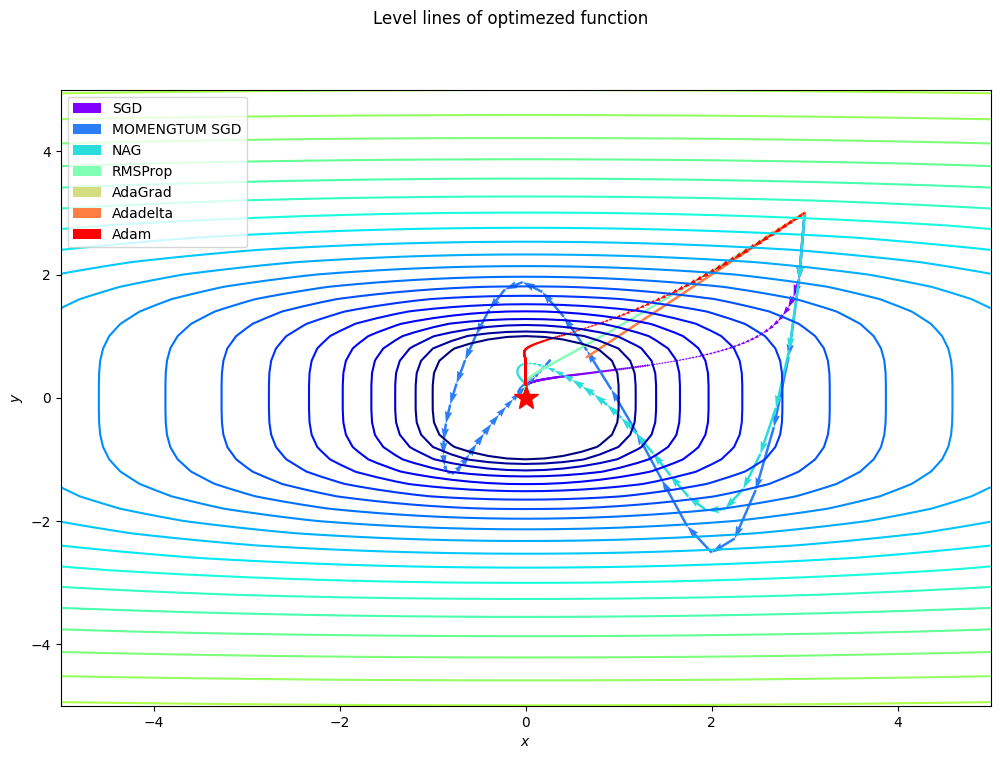

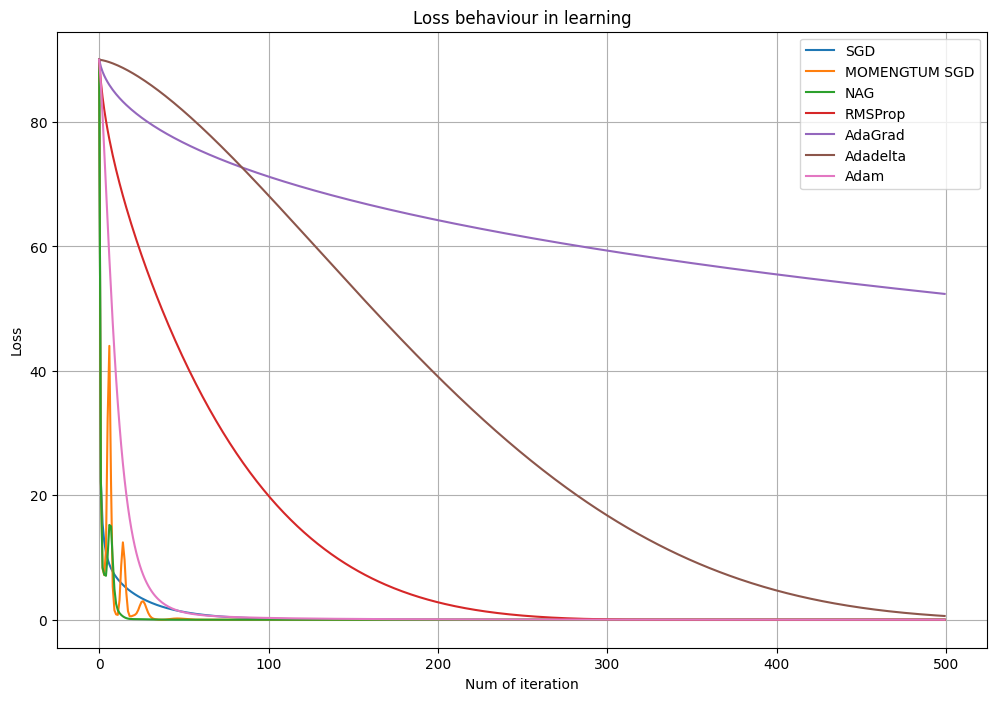

In [94]:
compare_optimizers(
    F1,
    [
        ('SGD', SGD, {}),
        ('MOMENGTUM SGD', Momentum, {"gamma": 0.9}),
        ('NAG', NAG, {"gamma": 0.8}),
        ('RMSProp', RMSProp, {"gamma": 0.9}),
        ('AdaGrad', AdaGrad, {}),
        ('Adadelta', Adadelta, {"gamma": 0.001}),
        ('Adam', Adam, {"learning_rate": 0.035}), 
    ],
    start_point=[3,3],
    minima=(0,0), # очевидно, что минимум глобальный и единственный в точке (0, 0)
    num_iter=500
)

### Сравните эти методы на функции $J(x, y) = x^2sin(x)+y^2sin(y)$

In [95]:
def F2(x, y):
    return (x ** 2) * torch.sin(x) + (y ** 2) * torch.sin(y)

/var/folders/_y/9291qqf96ggfppmhhxx_g3040000gq/T/ipykernel_16007/3780889576.py:22: UserWarning: Log scale: values of z <= 0 have been masked
  ax.contour(x, y, z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)


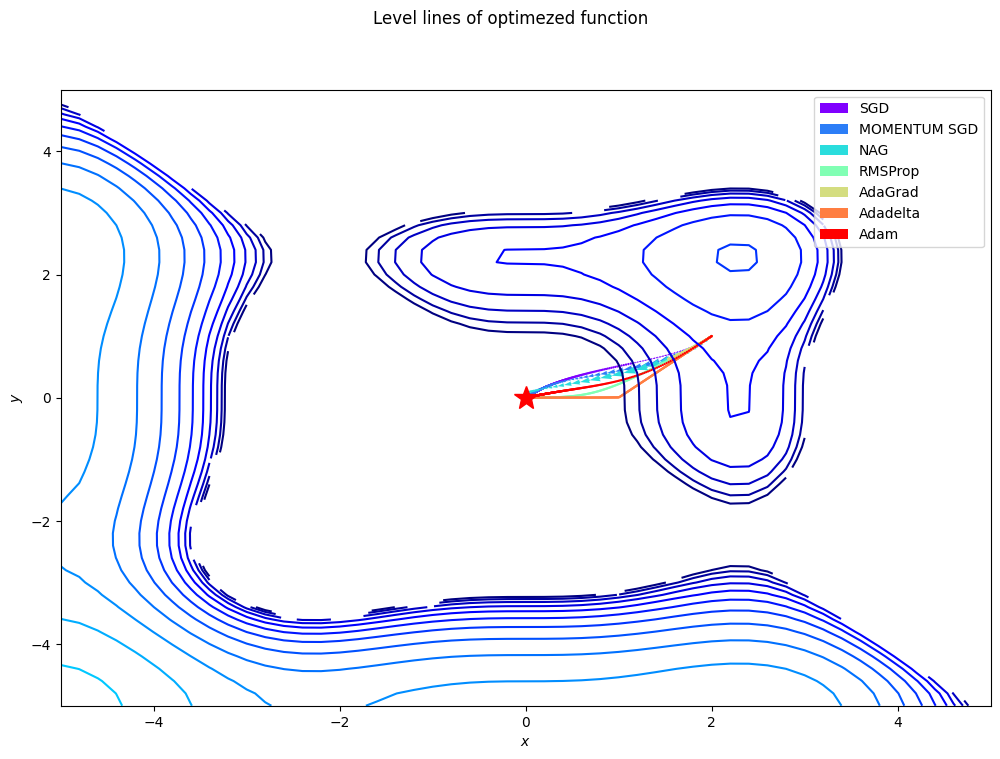

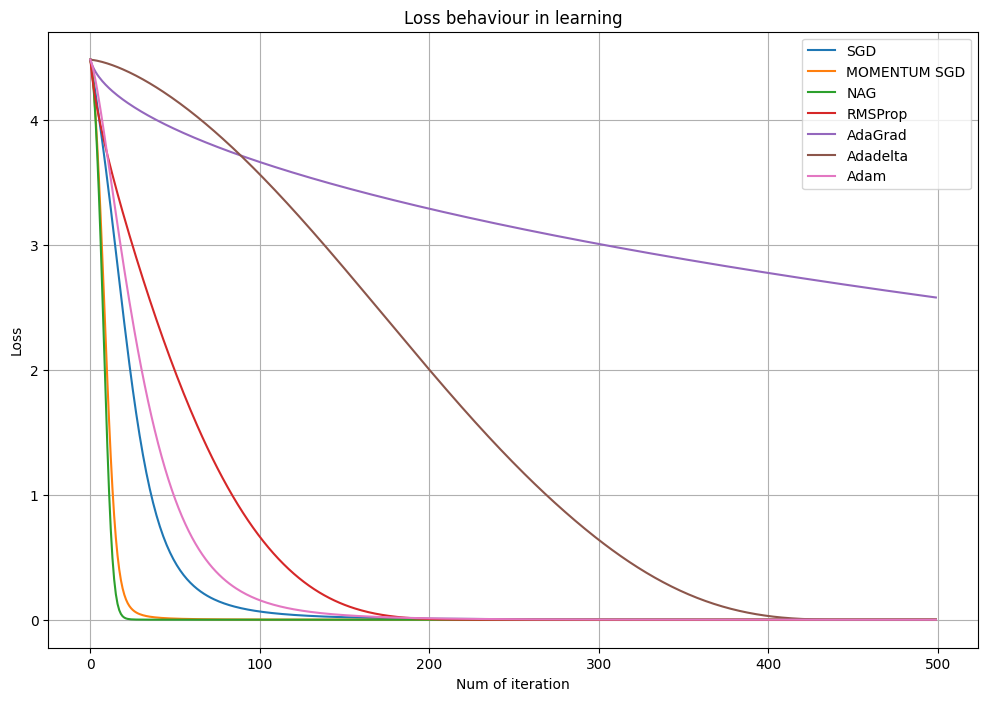

In [96]:
compare_optimizers(
    F2,
    [
        ('SGD', SGD, {}),
        ('MOMENTUM SGD', Momentum, {"gamma": 0.7}),
        ('NAG', NAG, {"gamma": 0.8}),
        ('RMSProp', RMSProp, {"gamma": 0.9}),
        ('AdaGrad', AdaGrad, {}),
        ('Adadelta', Adadelta, {"gamma": 0.001}),
        ('Adam', Adam, {"learning_rate": 0.01}), 
    ],
    start_point=[2,1],
    # очевидно, что глобальных минимумов несколько, оттого точка инициализации будет влиять на схождение
    minima=(0,0),
    num_iter=500
)

### Сравните эти методы на функции $J(x,y)=x^2sin(x^2)+y^2sin(y^2)$

In [97]:
def F3(x, y):
    return (x ** 2) * torch.sin(x ** 2) + (y ** 2) * torch.sin(y ** 2)

/var/folders/_y/9291qqf96ggfppmhhxx_g3040000gq/T/ipykernel_16007/3780889576.py:22: UserWarning: Log scale: values of z <= 0 have been masked
  ax.contour(x, y, z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)


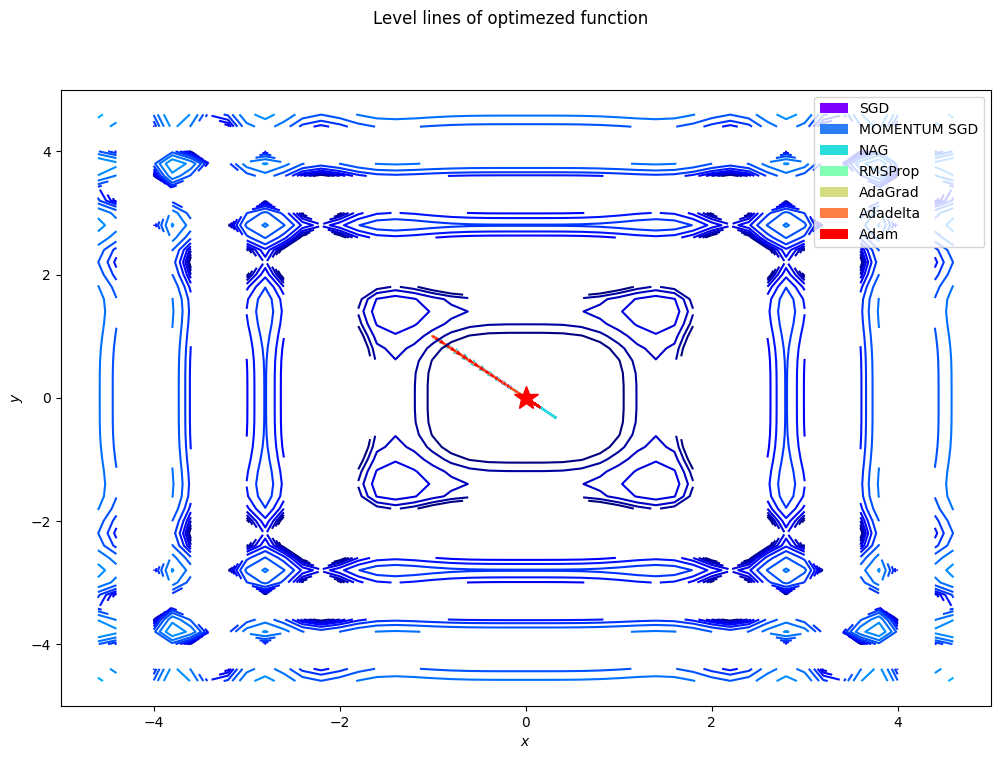

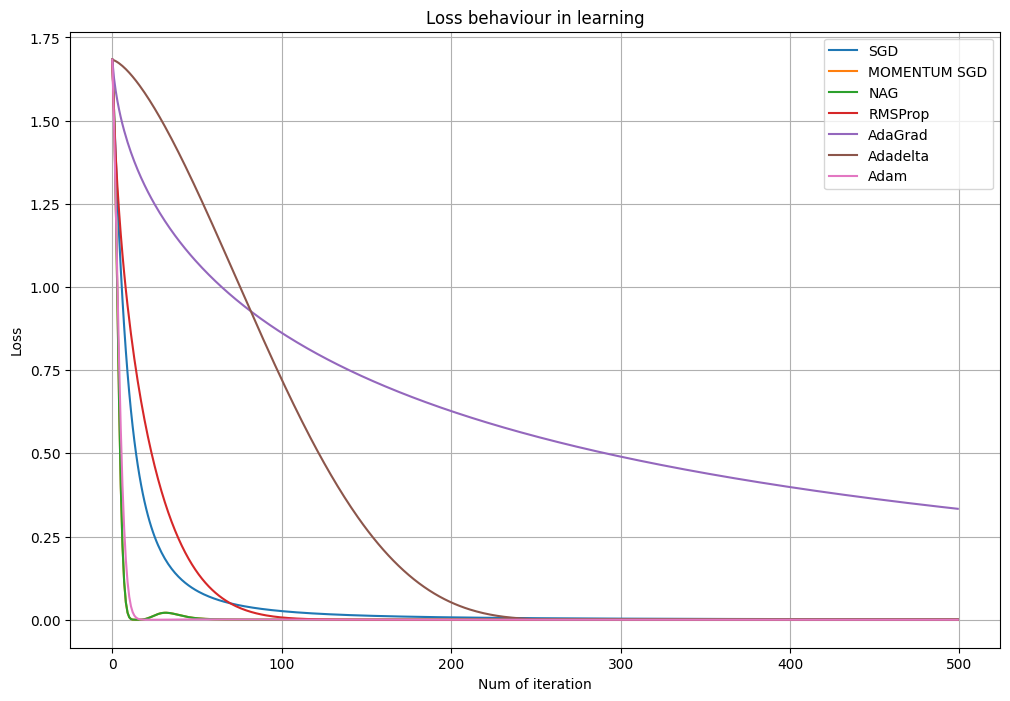

In [98]:
compare_optimizers(
    F3,
    [
        ('SGD', SGD, {}),
        ('MOMENTUM SGD', Momentum, {"gamma": 0.9}),
        ('NAG', NAG, {"gamma": 0.9}),
        ('RMSProp', RMSProp, {"gamma": 0.9}),
        ('AdaGrad', AdaGrad, {}),
        ('Adadelta', Adadelta, {"gamma": 0.001}),
        ('Adam', Adam, {"learning_rate": 0.035}), 
    ],
    start_point=[-1,1],
    # очевидно, что глобальных минимумов несколько, оттого точка инициализации будет влиять на схождение
    minima=(0,0),
    num_iter=500
)

###  Часть 2: Обучение нейронной сети

#### Сравните графики обучения для полносвязной нейросети на методах Adam, Adagrad, AdaDelta, RMSProp, SGD и Mometum SGD (на MNIST).  
Для обучения используйте оптимизаторы из первой части, а не из pytorch.

In [108]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

zsh:1: command not found: wget
tar: Error opening archive: Failed to open 'MNIST.tar.gz'


In [109]:
transform = transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('.', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('.', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

In [110]:
def run_net_learning_process(net, optimizer, train_loader, test_loader, 
                             epochs, criterion,
                             plot=True, verbose=True, conv=False
):

    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in tqdm(range(epochs)):
            losses = []
            num_of_correct_pred = 0
            for batch_idx, (data, target) in enumerate(train_loader):
                data, target = Variable(data), Variable(target)
                if not conv:
                    data = data.view(-1, 28*28) # изменим размер с (batch_size, 1, 28, 28) на (batch_size, 28*28)
                optimizer.zero_grad()
                net_out = net(data)
                loss = criterion(net_out, target)
                losses.append(loss.data.item())

                pred = net_out.data.max(1)[1]
                num_of_correct_pred += pred.eq(target.data).sum().item()
                loss.backward()

                optimizer.step()

            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(num_of_correct_pred / len(train_loader.dataset))

            losses = []
            num_of_correct_pred = 0
            for data, target in test_loader:
                data, target = Variable(data), Variable(target)
                if not conv:
                    data = data.view(-1, 28 * 28)
                net_out = net(data)
 
                loss = criterion(net_out, target)
                losses.append(loss.data.item())

                # sum up batch loss
                pred = net_out.data.max(1)[1]
                num_of_correct_pred += pred.eq(target.data).sum().item()

            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(num_of_correct_pred / len(test_loader.dataset))

            clear_output(wait=True) # для динамического обновления графиков, wait - очищает вывод

            if verbose: # детализация выводимой информации
                print(
                      f'Network: <{type(net).__name__}>\n'
                      f'Optimizer: <{type(optimizer).__name__}>\n'
                      f'Loss type: <{type(criterion).__name__}>\n\n'
                      f'Epoch: {epoch+1}\n'
                      f'<Train/Test>\n'
                      f'Loss: {np.round(train_loss_epochs[-1], 3)}/{np.round(test_loss_epochs[-1], 3)} '
                      f'| Accuracy: {np.round(train_accuracy_epochs[-1], 3)}/{np.round(test_accuracy_epochs[-1], 3)}'
                     )

            if plot:
                plt.figure(figsize=(12, 5))

                # Отображение изменения ошибки
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.plot(test_loss_epochs, label='Test')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')

                # Отображение изменения accuracy
                plt.subplot(1, 2, 2)
                plt.plot(train_accuracy_epochs, label='Train')
                plt.plot(test_accuracy_epochs, label='Test')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Accuracy', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.show()
    except KeyboardInterrupt as KI:
        print(KI)

    return train_loss_epochs, \
       test_loss_epochs, \
       train_accuracy_epochs, \
       test_accuracy_epochs

In [111]:
def compare_activation_func(loss_results: list, acc_results: list, labels: list) -> None:
    plt.figure(figsize=(15, 7))

    plt.subplot(1, 2, 1)
    for loss_result, label in zip(loss_results, labels):
        plt.plot(loss_result, label=label)

    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(fontsize=10)
    plt.grid()

    plt.subplot(1, 2, 2)
    for acc_result, label in zip(acc_results, labels):
        plt.plot(acc_result, label=label)

    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Accuracy', fontsize=16)
    plt.legend(fontsize=10)
    plt.grid()
    plt.show()

In [112]:
import torch.nn as nn
import torch.nn.functional as F

class FullyConnectedNN(nn.Module):
    def __init__(self):
        super(FullyConnectedNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 10)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

In [113]:
NUM_EPOCHS=10
nets = [FullyConnectedNN() for i in range(7)]
print(nets[0])

FullyConnectedNN(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)


In [114]:
optimizers = [
                SGD(parameters=nets[0].parameters(), learning_rate=0.01),
                Momentum(parameters=nets[1].parameters(), learning_rate=0.01, gamma=0.9),
                NAG(parameters=nets[2].parameters(), learning_rate=0.01, gamma=0.9),
                RMSProp(parameters=nets[3].parameters(), learning_rate=0.01, gamma=0.9),
                Adadelta(parameters=nets[4].parameters(), gamma=0.9),
                AdaGrad(parameters=nets[5].parameters(), learning_rate=0.01),
                Adam(parameters=nets[6].parameters(), learning_rate=0.005, beta_1=0.9, beta_2=0.99),
            ]
criterion = nn.NLLLoss()

Network: <FullyConnectedNN>
Optimizer: <SGD>
Loss type: <NLLLoss>

Epoch: 10
<Train/Test>
Loss: 0.067/0.08 | Accuracy: 0.98/0.974


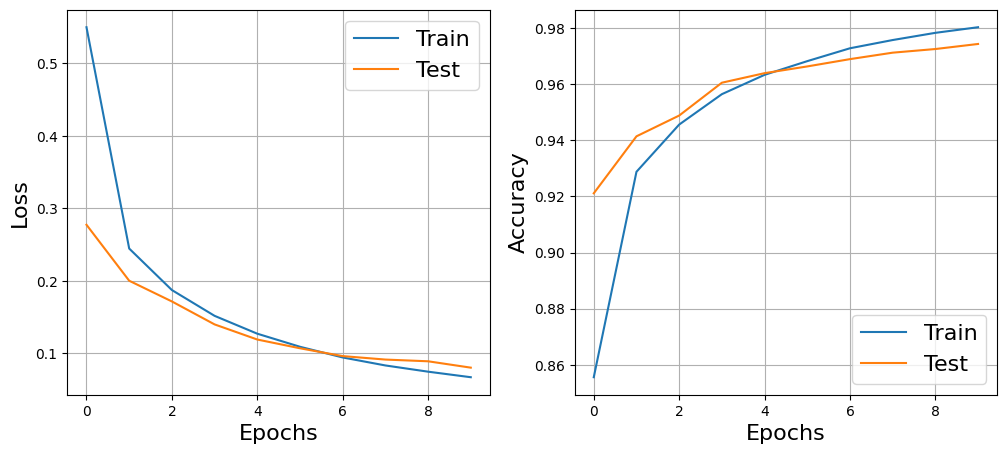

In [115]:
tr_sgd, ts_sgd, tr_ac_sgd, ts_ac_sgd =\
run_net_learning_process(
    net=nets[0], optimizer=optimizers[0], epochs=NUM_EPOCHS, criterion=criterion,
    train_loader=train_loader, test_loader=test_loader, 
    plot=True, verbose=True,
)

Network: <FullyConnectedNN>
Optimizer: <Momentum>
Loss type: <NLLLoss>

Epoch: 10
<Train/Test>
Loss: 0.017/0.095 | Accuracy: 0.994/0.977


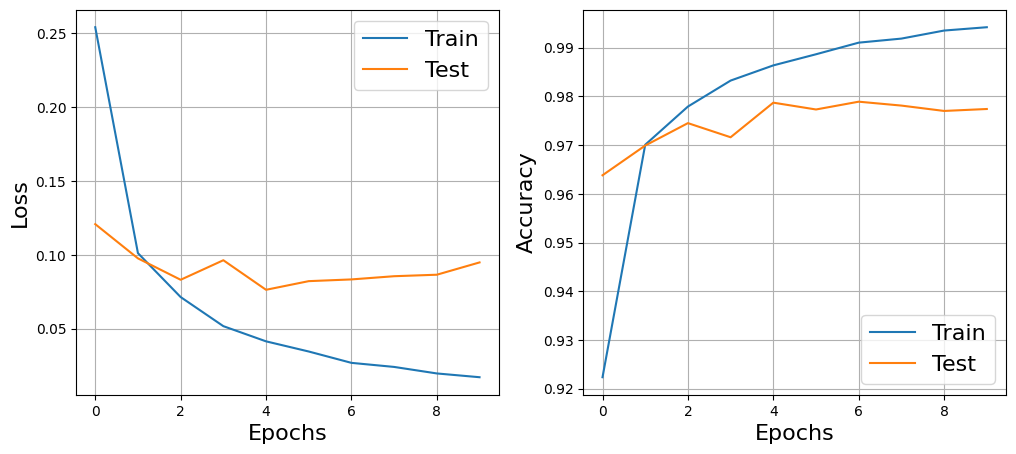

In [116]:
tr_mom, ts_mom, tr_ac_mom, ts_ac_mom =\
run_net_learning_process(
    net=nets[1], optimizer=optimizers[1], epochs=NUM_EPOCHS, criterion=criterion,
    train_loader=train_loader, test_loader=test_loader, 
    plot=True, verbose=True,
)

Network: <FullyConnectedNN>
Optimizer: <NAG>
Loss type: <NLLLoss>

Epoch: 10
<Train/Test>
Loss: 0.013/0.09 | Accuracy: 0.996/0.979


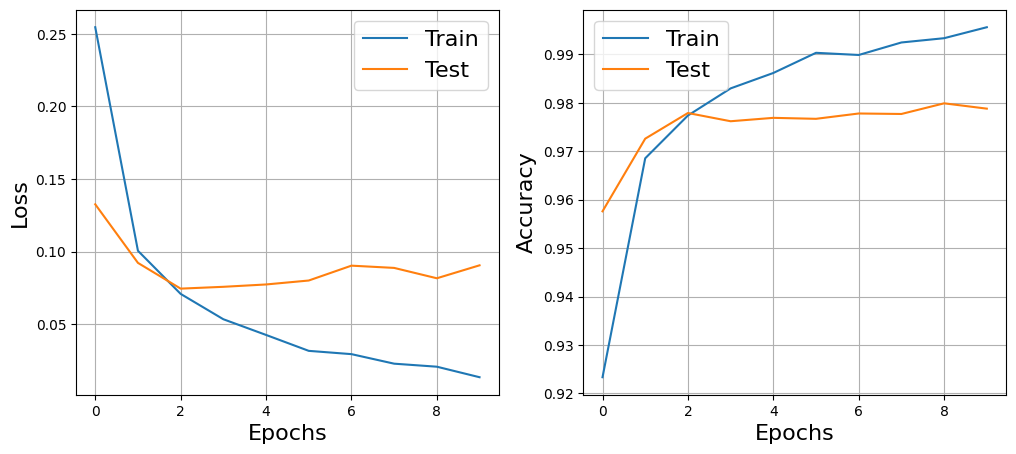

In [117]:
tr_nag, ts_nag, tr_ac_nag, ts_ac_nag =\
run_net_learning_process(
    net=nets[2], optimizer=optimizers[2], epochs=NUM_EPOCHS, criterion=criterion,
    train_loader=train_loader, test_loader=test_loader, 
    plot=True, verbose=True,
)

Network: <FullyConnectedNN>
Optimizer: <RMSProp>
Loss type: <NLLLoss>

Epoch: 10
<Train/Test>
Loss: 0.849/1.502 | Accuracy: 0.844/0.858


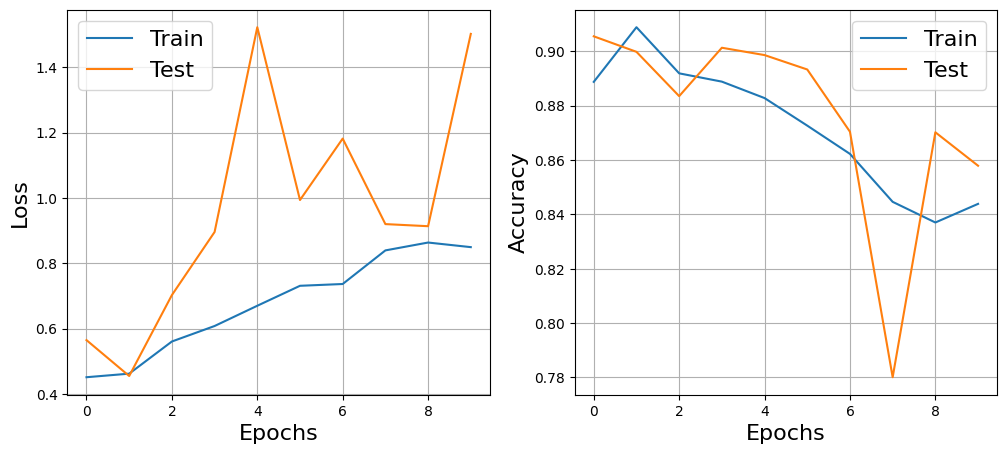

In [118]:
tr_rms, ts_rms, tr_ac_rms, ts_ac_rms =\
run_net_learning_process(
    net=nets[3], optimizer=optimizers[3], epochs=NUM_EPOCHS, criterion=criterion,
    train_loader=train_loader, test_loader=test_loader, 
    plot=True, verbose=True,
)

Network: <FullyConnectedNN>
Optimizer: <Adadelta>
Loss type: <NLLLoss>

Epoch: 10
<Train/Test>
Loss: 0.023/0.098 | Accuracy: 0.993/0.979


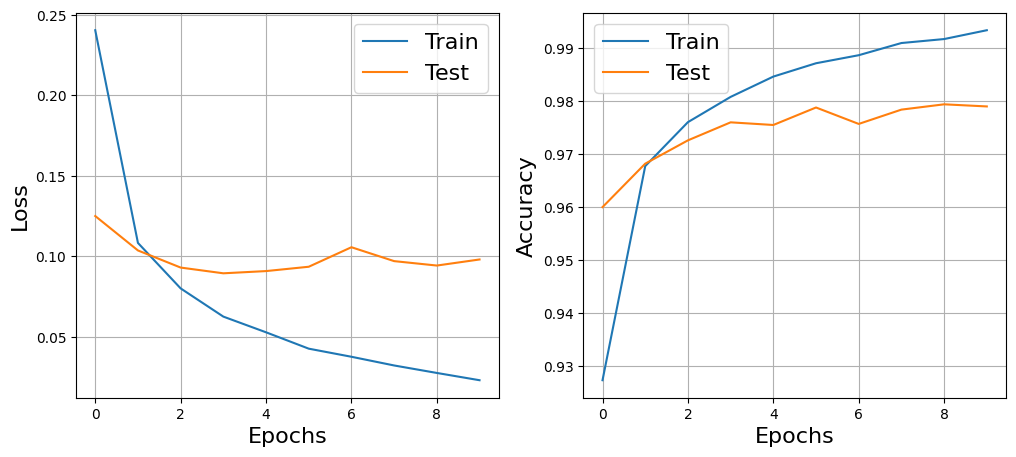

In [119]:
tr_add, ts_add, tr_ac_add, ts_ac_add =\
run_net_learning_process(
    net=nets[4], optimizer=optimizers[4], epochs=NUM_EPOCHS, criterion=criterion,
    train_loader=train_loader, test_loader=test_loader, 
    plot=True, verbose=True,
)

Network: <FullyConnectedNN>
Optimizer: <AdaGrad>
Loss type: <NLLLoss>

Epoch: 10
<Train/Test>
Loss: 0.041/0.073 | Accuracy: 0.988/0.978


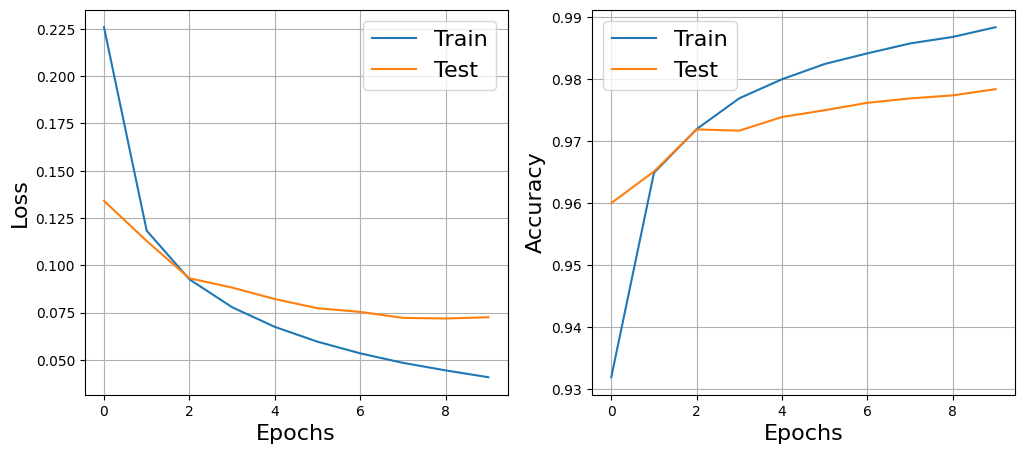

In [120]:
tr_adg, ts_adg, tr_ac_adg, ts_ac_adg =\
run_net_learning_process(
    net=nets[5], optimizer=optimizers[5], epochs=NUM_EPOCHS, criterion=criterion,
    train_loader=train_loader, test_loader=test_loader, 
    plot=True, verbose=True,
)

Network: <FullyConnectedNN>
Optimizer: <Adam>
Loss type: <NLLLoss>

Epoch: 10
<Train/Test>
Loss: 0.099/0.154 | Accuracy: 0.975/0.966


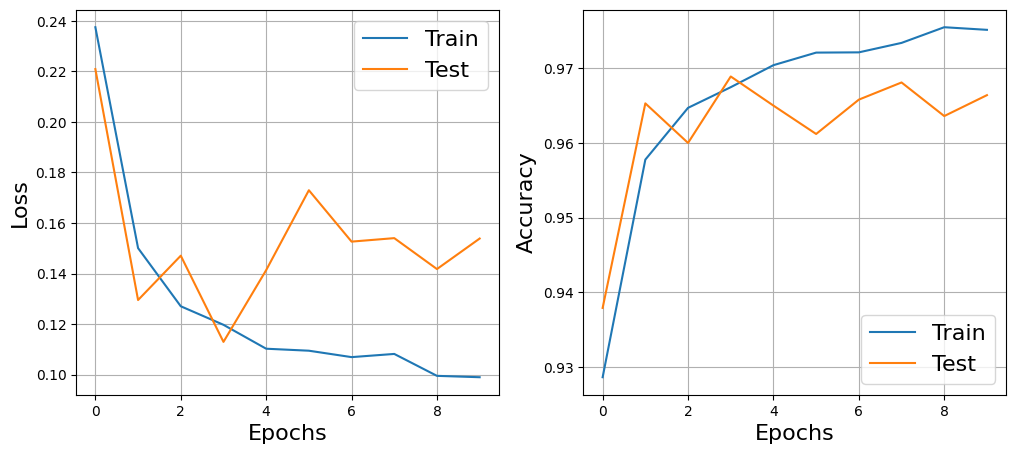

In [121]:
tr_adm, ts_adm, tr_ac_adm, ts_ac_adm =\
run_net_learning_process(
    net=nets[6], optimizer=optimizers[6], epochs=NUM_EPOCHS, criterion=criterion,
    train_loader=train_loader, test_loader=test_loader, 
    plot=True, verbose=True,
)

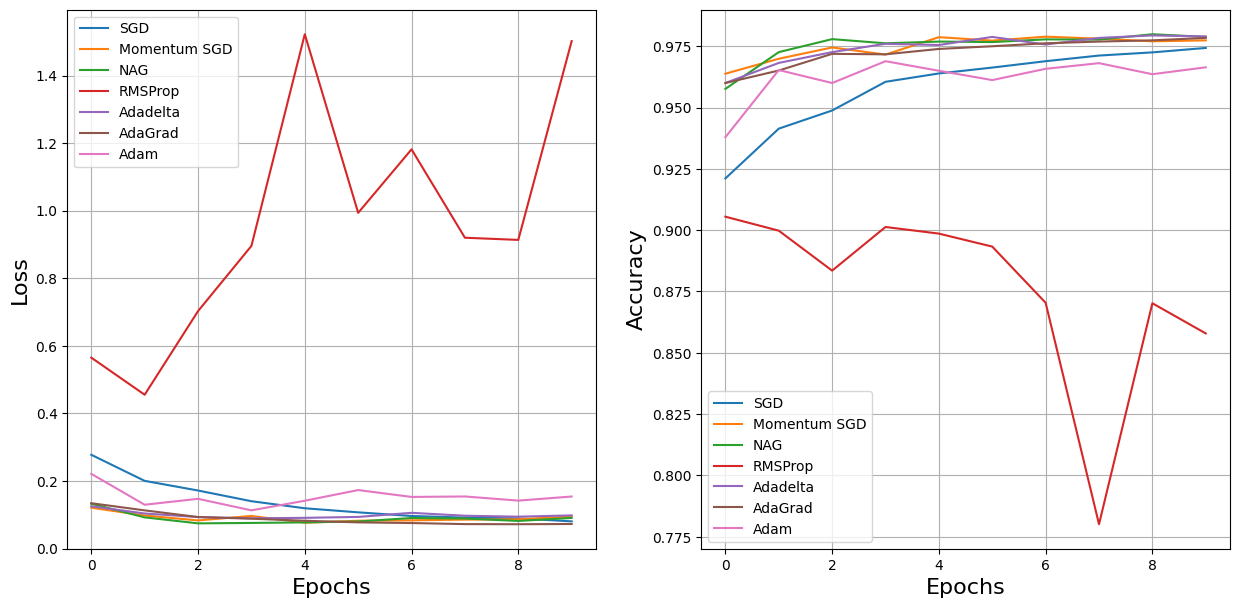

In [122]:
compare_activation_func(
    loss_results=[ts_sgd, ts_mom, ts_nag, ts_rms, ts_add, ts_adg, ts_adm], 
    acc_results=[ts_ac_sgd, ts_ac_mom, ts_ac_nag, ts_ac_rms, ts_ac_add, ts_ac_adg, ts_ac_adm],
    labels=["SGD", "Momentum SGD", "NAG", "RMSProp", "Adadelta", "AdaGrad", "Adam"],
)

#### Сравните графики обучения для сверточной нейросети на методах Adam, Adagrad, AdaDelta, RMSProp, SGD и Mometum SGD.

In [123]:
IMAGE_SIZE = 28
CHANNELS = 1
class ConvClassifier(nn.Module):
    def __init__(self, image_size):
        super(ConvClassifier, self).__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(CHANNELS, 3, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2))
        self.linear_layers = nn.Sequential(nn.Linear(image_size//2*image_size//2*3, 10), nn.LogSoftmax(dim=1))
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [124]:
NUM_EPOCHS=10
cnn_nets = [ConvClassifier(image_size=IMAGE_SIZE) for i in range(7)]
print(cnn_nets[0])

ConvClassifier(
  (conv_layers): Sequential(
    (0): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=588, out_features=10, bias=True)
    (1): LogSoftmax(dim=1)
  )
)


In [125]:
optimizers = [
                SGD(parameters=cnn_nets[0].parameters(), learning_rate=0.01),
                Momentum(parameters=cnn_nets[1].parameters(), learning_rate=0.01, gamma=0.9),
                NAG(parameters=cnn_nets[2].parameters(), learning_rate=0.01, gamma=0.9),
                RMSProp(parameters=cnn_nets[3].parameters(), learning_rate=0.01, gamma=0.9),
                Adadelta(parameters=cnn_nets[4].parameters(), gamma=0.9),
                AdaGrad(parameters=cnn_nets[5].parameters(), learning_rate=0.01),
                Adam(parameters=cnn_nets[6].parameters(), learning_rate=0.005, beta_1=0.9, beta_2=0.99),
            ]
criterion = nn.NLLLoss()

Network: <ConvClassifier>
Optimizer: <SGD>
Loss type: <NLLLoss>

Epoch: 10
<Train/Test>
Loss: 0.089/0.085 | Accuracy: 0.974/0.973


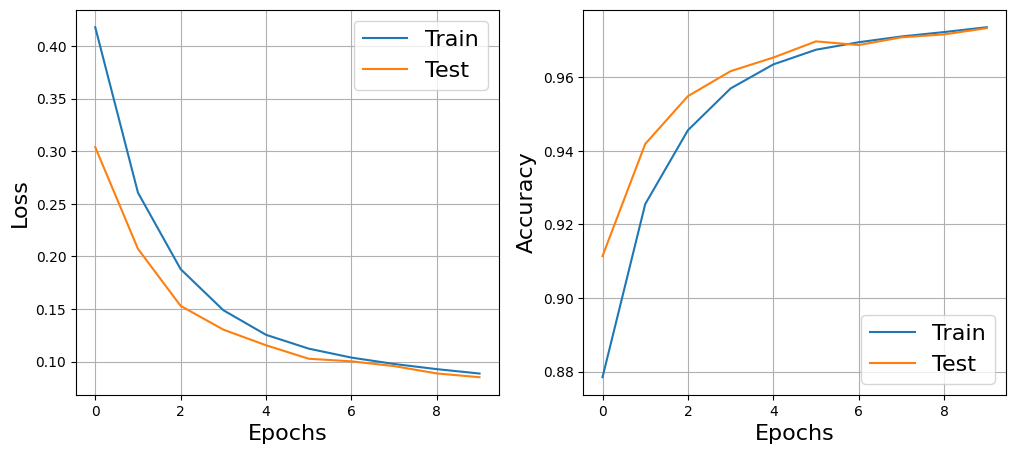

In [126]:
tr_sgd, ts_sgd, tr_ac_sgd, ts_ac_sgd =\
run_net_learning_process(
    net=cnn_nets[0], optimizer=optimizers[0], epochs=NUM_EPOCHS, criterion=criterion,
    train_loader=train_loader, test_loader=test_loader, 
    plot=True, verbose=True, conv=True,
)

Network: <ConvClassifier>
Optimizer: <Momentum>
Loss type: <NLLLoss>

Epoch: 10
<Train/Test>
Loss: 0.084/0.097 | Accuracy: 0.974/0.97


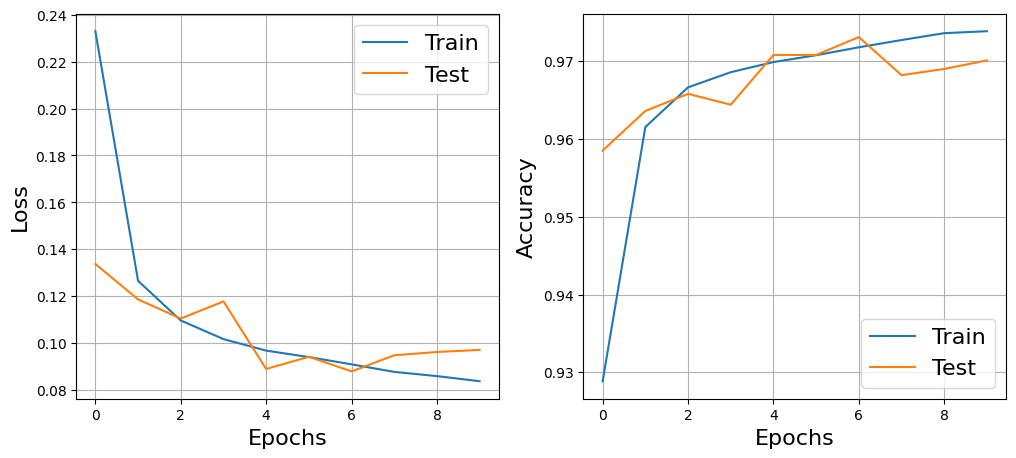

In [127]:
tr_mom, ts_mom, tr_ac_mom, ts_ac_mom =\
run_net_learning_process(
    net=cnn_nets[1], optimizer=optimizers[1], epochs=NUM_EPOCHS, criterion=criterion,
    train_loader=train_loader, test_loader=test_loader, 
    plot=True, verbose=True, conv=True,
)

Network: <ConvClassifier>
Optimizer: <NAG>
Loss type: <NLLLoss>

Epoch: 10
<Train/Test>
Loss: 0.07/0.076 | Accuracy: 0.978/0.976


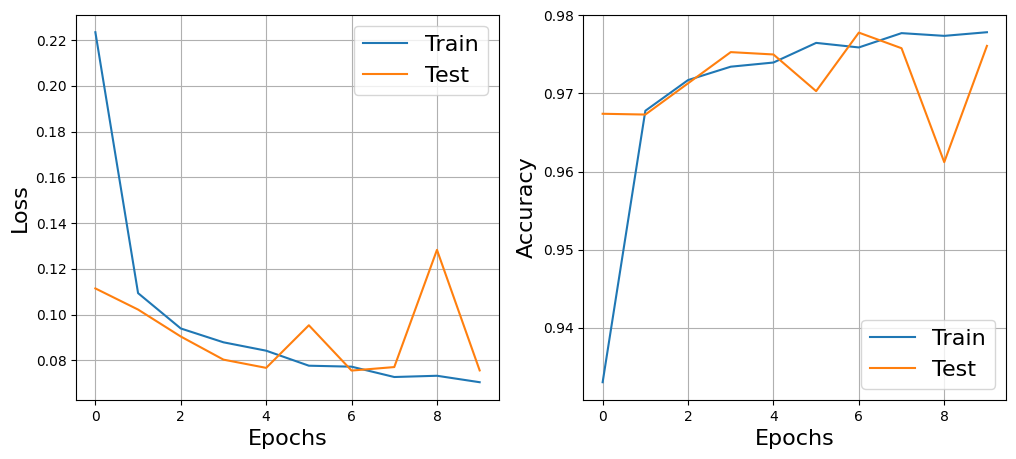

In [128]:
tr_nag, ts_nag, tr_ac_nag, ts_ac_nag =\
run_net_learning_process(
    net=cnn_nets[2], optimizer=optimizers[2], epochs=NUM_EPOCHS, criterion=criterion,
    train_loader=train_loader, test_loader=test_loader, 
    plot=True, verbose=True, conv=True,
)

Network: <ConvClassifier>
Optimizer: <RMSProp>
Loss type: <NLLLoss>

Epoch: 10
<Train/Test>
Loss: 0.123/0.117 | Accuracy: 0.966/0.965


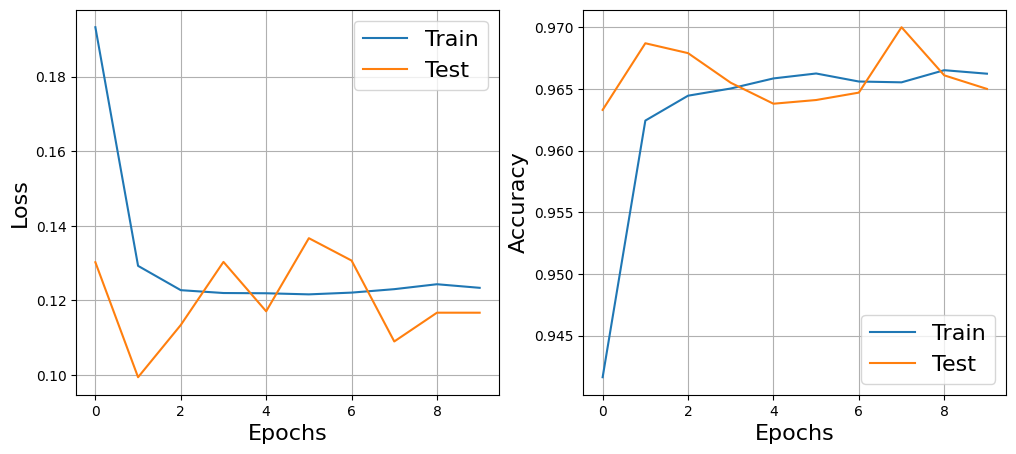

In [129]:
tr_rms, ts_rms, tr_ac_rms, ts_ac_rms =\
run_net_learning_process(
    net=cnn_nets[3], optimizer=optimizers[3], epochs=NUM_EPOCHS, criterion=criterion,
    train_loader=train_loader, test_loader=test_loader, 
    plot=True, verbose=True, conv=True,
)

Network: <ConvClassifier>
Optimizer: <Adadelta>
Loss type: <NLLLoss>

Epoch: 10
<Train/Test>
Loss: 0.101/0.105 | Accuracy: 0.97/0.967


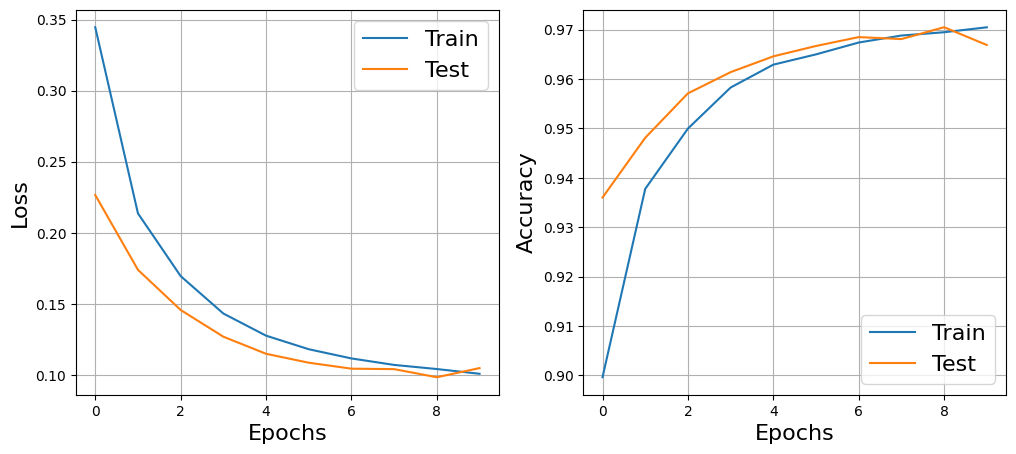

In [130]:
tr_add, ts_add, tr_ac_add, ts_ac_add =\
run_net_learning_process(
    net=cnn_nets[4], optimizer=optimizers[4], epochs=NUM_EPOCHS, criterion=criterion,
    train_loader=train_loader, test_loader=test_loader, 
    plot=True, verbose=True, conv=True,
)

Network: <ConvClassifier>
Optimizer: <AdaGrad>
Loss type: <NLLLoss>

Epoch: 10
<Train/Test>
Loss: 0.176/0.173 | Accuracy: 0.951/0.952


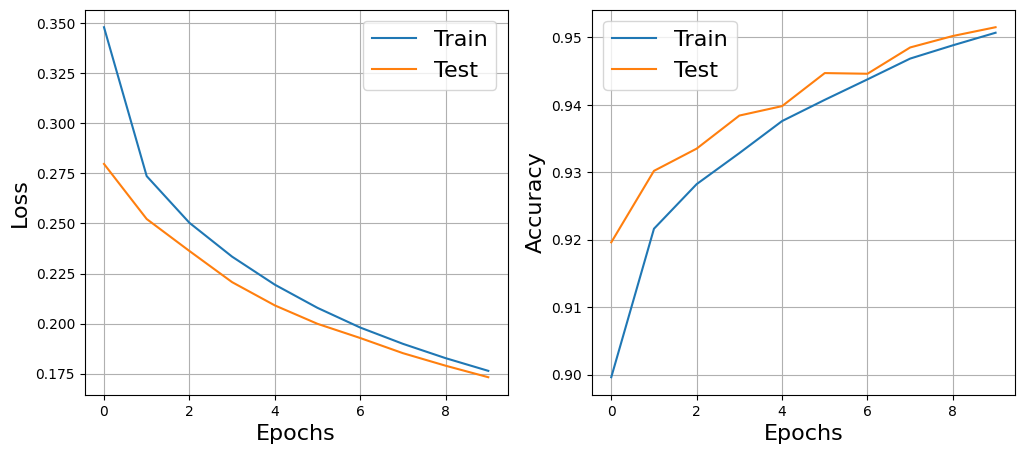

In [131]:
tr_adg, ts_adg, tr_ac_adg, ts_ac_adg =\
run_net_learning_process(
    net=cnn_nets[5], optimizer=optimizers[5], epochs=NUM_EPOCHS, criterion=criterion,
    train_loader=train_loader, test_loader=test_loader, 
    plot=True, verbose=True, conv=True,
)

Network: <ConvClassifier>
Optimizer: <Adam>
Loss type: <NLLLoss>

Epoch: 10
<Train/Test>
Loss: 0.068/0.087 | Accuracy: 0.98/0.974


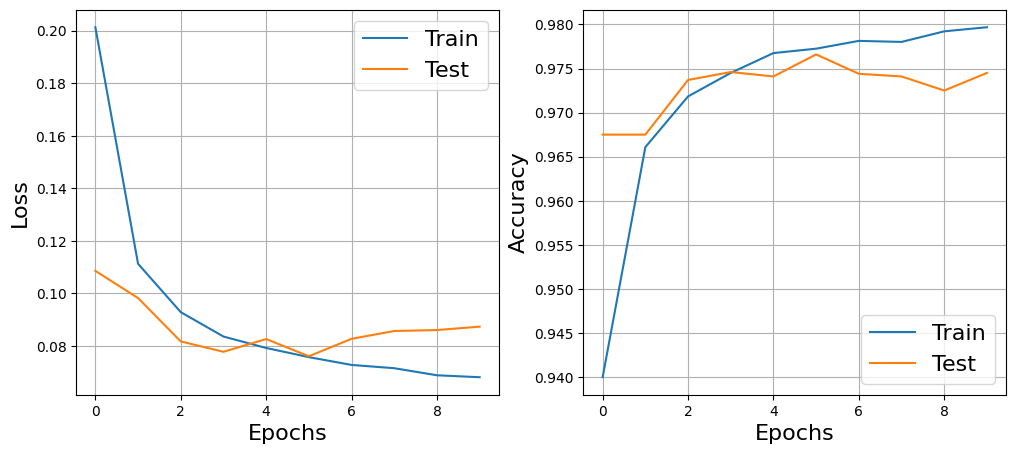

In [132]:
tr_adm, ts_adm, tr_ac_adm, ts_ac_adm =\
run_net_learning_process(
    net=cnn_nets[6], optimizer=optimizers[6], epochs=NUM_EPOCHS, criterion=criterion,
    train_loader=train_loader, test_loader=test_loader, 
    plot=True, verbose=True, conv=True,
)

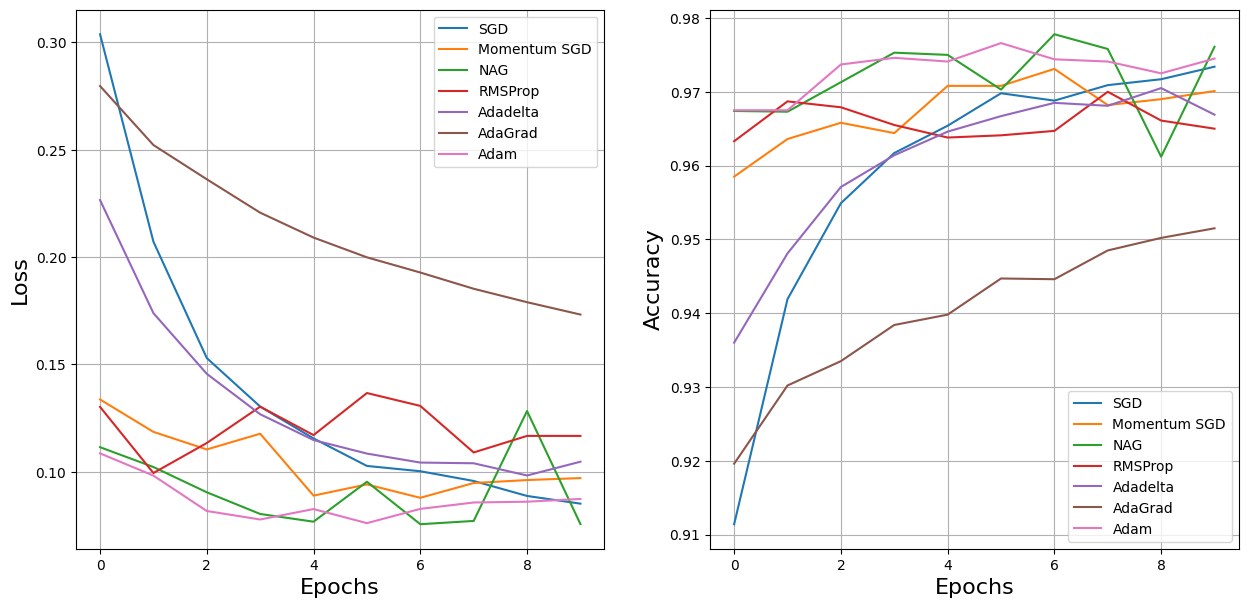

In [133]:
compare_activation_func(
    loss_results=[ts_sgd, ts_mom, ts_nag, ts_rms, ts_add, ts_adg, ts_adm], 
    acc_results=[ts_ac_sgd, ts_ac_mom, ts_ac_nag, ts_ac_rms, ts_ac_add, ts_ac_adg, ts_ac_adm],
    labels=["SGD", "Momentum SGD", "NAG", "RMSProp", "Adadelta", "AdaGrad", "Adam"],
)

В целом, можно отметить удовлетворительное качество модели с оптимизаторами с найстройками по умолчанию.
На полносвязной сети RMSProp явно не смог найти глобальный минимум и сместил свое направление, на сверточной нейронной сети такого эффекта не наблюдается.
Заметим, что время, затраченное на обучение как полносвязной, так и сверточной нейросетей не превышает 3 мин